In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("../.venv/lib/python3.9/site-packages/")
sys.path.append("..")

In [32]:
from typing import Any

import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel, norm

from formatting import set_size
from sklearn.linear_model import BayesianRidge

from coordination.model.coordination_blending_latent_vocalics import LatentVocalicsDataset

In [75]:
NUM_SAMPLES = 70
X_train = np.arange(10, NUM_SAMPLES + 10)[:, np.newaxis]
y_train = (X_train + norm(loc=0, scale=1).rvs(NUM_SAMPLES)[:, np.newaxis]).flatten()
y_train[30:] = (X_train[30:] + norm(loc=0, scale=20).rvs(NUM_SAMPLES-30)[:, np.newaxis]).flatten()
X_test = X_train
y_test = y_train

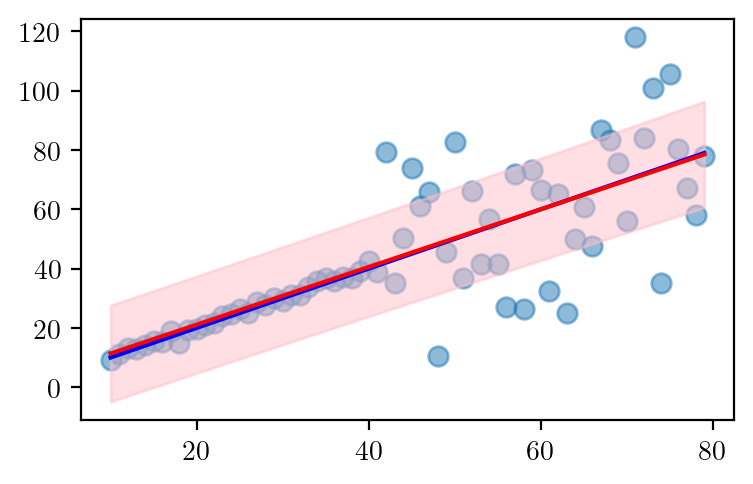

In [83]:
reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
reg.set_params(alpha_init=1, lambda_init=1)
reg.fit(X_train, y_train)

ymean, ystd = reg.predict(X_test, return_std=True)

plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 1, figsize=set_size("research_notebook", fraction=1))
ax.plot(X_test.flatten(), X_test.flatten(), color="blue", label="original")
ax.scatter(X_train.flatten(), y_train, s=50, alpha=0.5, label="observation")
ax.plot(X_test.flatten(), ymean, color="red", label="predict mean")
ax.fill_between(X_test.flatten(), ymean - ystd, ymean + ystd, color="pink", alpha=0.5, label="predict std")

In [78]:
ystd

array([16.27460779, 16.28050865, 16.28696906, 16.29398833, 16.30156575,
       16.30970053, 16.31839186, 16.32763883, 16.3374405 , 16.34779588,
       16.35870391, 16.37016349, 16.38217346, 16.39473262, 16.4078397 ,
       16.42149338, 16.43569231, 16.45043508, 16.46572022, 16.48154623,
       16.49791154, 16.51481456, 16.53225364, 16.55022708, 16.56873314,
       16.58777004, 16.60733595, 16.62742902, 16.64804732, 16.6691889 ,
       16.69085179, 16.71303396, 16.73573333, 16.75894781, 16.78267526,
       16.8069135 , 16.83166034, 16.85691353, 16.88267079, 16.90892983,
       16.93568831, 16.96294387, 16.99069411, 17.01893662, 17.04766895,
       17.07688862, 17.10659314, 17.13677999, 17.16744662, 17.19859047,
       17.23020895, 17.26229945, 17.29485934, 17.32788598, 17.3613767 ,
       17.39532883, 17.42973966, 17.46460649, 17.49992659, 17.53569722,
       17.57191563, 17.60857905, 17.64568472, 17.68322985, 17.72121164,
       17.7596273 , 17.79847401, 17.83774896, 17.87744932, 17.91

In [3]:
PLOTS_DIR = "/Users/paulosoares/manuscript/experimental_agenda/figures"

def save_plot(fig: Any, name: str):
    fig.savefig(f"{PLOTS_DIR}/{name}.pdf", format='pdf', bbox_inches='tight')

In [16]:
def load_datasets(advisor: str):
    with open(f"../data/study-3_2022/{advisor}/datasets/mission1_dataset.pkl", "rb") as f:
        mission1_dataset = pickle.load(f)
    
    with open(f"../data/study-3_2022/{advisor}/datasets/mission2_dataset.pkl", "rb") as f:
        mission2_dataset = pickle.load(f)
    
    with open(f"../data/study-3_2022/{advisor}/datasets/all_missions_dataset.pkl", "rb") as f:
        all_missions_dataset = pickle.load(f)
    
    return mission1_dataset, mission2_dataset, all_missions_dataset

In [17]:
def get_ages_and_genders(mission1_dataset: LatentVocalicsDataset, mission2_dataset: LatentVocalicsDataset):
    """
    Gets ages and genders for distinct teams. If there are entries for mission 1 and mission 2 of the same team,
    it only stores player's age and gender once
    """
    ages = {}  # trial_number: players' age
    genders = {}  # trial_number: players' gender
        
    for i in range(mission1_dataset.num_trials):
        mission1_trial_number = int(mission1_dataset.series[i].uuid[1:])
        ages[mission1_trial_number] = mission1_dataset.ages[i]
        genders[mission1_trial_number] = mission1_dataset.genders[i]
        
    for i in range(mission2_dataset.num_trials):
        mission2_trial_number = int(mission2_dataset.series[i].uuid[1:])
        mission1_trial_number = mission2_trial_number - 1
        
        if mission1_trial_number not in ages.keys():
            ages[mission2_trial_number] = mission2_dataset.ages[i]
            genders[mission2_trial_number] = mission2_dataset.genders[i]
    
    # Remove non-informed ages (<= 0)
    ages = [age for ages_per_player in ages.values() for age in ages_per_player if age > 0]
    genders = [gender for genders_per_player in genders.values() for gender in genders_per_player]
    
    return ages, genders

def get_paired_outcome_measures(mission1_dataset: LatentVocalicsDataset, mission2_dataset: LatentVocalicsDataset):
    """
    Gets outcome measures (score and surveys) for the same teams in mission 1 and 2. Ignores data from
    trials with only one mission.
    """
    
    mission1 = {}
    mission2 = {}
    mission1_trial_numbers = []
        
    for i in range(mission1_dataset.num_trials):
        mission_trial_number = int(mission1_dataset.series[i].uuid[1:])
        mission1[mission_trial_number] = (
            mission1_dataset.team_scores[i],
            mission1_dataset.team_process_surveys[i],
            mission1_dataset.team_satisfaction_surveys[i],
        )
        
    for i in range(mission2_dataset.num_trials):
        mission_trial_number = int(mission2_dataset.series[i].uuid[1:])
        if mission_trial_number - 1 in mission1:
            # Only add if exists an entry for mission 1
            mission1_trial_numbers.append(mission_trial_number - 1)
        
            mission2[mission_trial_number] = (
                mission2_dataset.team_scores[i],
                mission2_dataset.team_process_surveys[i],
                mission2_dataset.team_satisfaction_surveys[i],
            )
    
    scores1 = []
    scores2 = []
    process_survey1 = []
    process_survey2 = []
    satisfaction_survey1 = []
    satisfaction_survey2 = []
    for mission1_trial_number in mission1_trial_numbers:
        scores1.append(mission1[mission1_trial_number][0])
        scores2.append(mission2[mission1_trial_number + 1][0])
        
        process_survey1.append(np.mean(mission1[mission1_trial_number][1]))
        process_survey2.append(np.mean(mission2[mission1_trial_number + 1][1]))
        
        satisfaction_survey1.append(np.mean(mission1[mission1_trial_number][2]))
        satisfaction_survey2.append(np.mean(mission2[mission1_trial_number + 1][2]))
    
    return (scores1, process_survey1, satisfaction_survey1), (scores2, process_survey2, satisfaction_survey2)

In [18]:
# Loading all datasets
tomcat_m1_dataset, tomcat_m2_dataset, tomcat_all_dataset = load_datasets("tomcat_advisor")
human_m1_dataset, human_m2_dataset, human_all_dataset = load_datasets("human_advisor")
no_m1_dataset, no_m2_dataset, no_all_dataset = load_datasets("no_advisor")

# All advisor conditions
m1_dataset = tomcat_m1_dataset.merge(human_m1_dataset).merge(no_m1_dataset)
m2_dataset = tomcat_m2_dataset.merge(human_m2_dataset).merge(no_m2_dataset)
all_dataset = tomcat_all_dataset.merge(human_all_dataset).merge(no_all_dataset)

# Demographics

In [6]:
ages, genders = get_ages_and_genders(m1_dataset, m2_dataset)

Age: 21.74380165289256 +/- 5.748918584071117

Male: 73.98373983739837%
Female: 20.32520325203252%
Undetermined: 5.691056910569106%


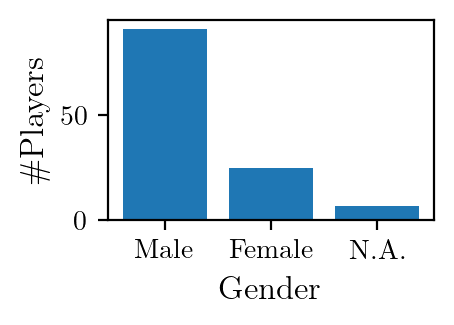

In [32]:
print(f"Age: {np.mean(ages)} +/- {np.std(ages)}")

gender_map = {0: "Male", 1: "Female", 2: "N.A.", 3: "N.A."}
gender_bar = {gender: 0 for gender in gender_map.values()}
for gender in genders:
    gender_bar[gender_map[gender]] += 1
    
total_players = len(genders)
print("")
print(f"Male: {100 * gender_bar['Male']/total_players}%")
print(f"Female: {100 * gender_bar['Female']/total_players}%")
print(f"Undetermined: {100 * gender_bar['N.A.']/total_players}%")

plt.style.use("research_notebook")
fig, ax = plt.subplots(1, 1, figsize=set_size("research_notebook", fraction=0.5))
_ = ax.bar(gender_bar.keys(), gender_bar.values())
# ax.plot(xs, ys1, marker="o", markersize=3)
# ax.fill_between(xs, ys1 - errs1, ys1 + errs1, alpha=0.5)
# ax.plot(xs, ys2, marker="o", markersize=3)
# ax.fill_between(xs, ys2 - errs2, ys2 + errs2, alpha=0.5)
# ax.set_xlim(0, T)
_ = ax.set_xlabel(r"Gender")
_ = ax.set_ylabel(r"\#Players")

save_plot(fig, "genders_bar")

# No Advisor

In [30]:
print(f"Num Mission 1 Trials: {no_m1_dataset.num_trials}")
print(f"Num Mission 2 Trials: {no_m2_dataset.num_trials}")

Num Mission 1 Trials: 12
Num Mission 2 Trials: 14


##     Mission 1 vs Mission 2 Hypotheses

$H_0$: Average outcome measure is equal or smaller in mission 2 for the same team

$H_1$: Average outcome measure is larger in mission 2 for the same team 

In [55]:
(scores1, process_survey1, satisfaction_survey1), (scores2, process_survey2, satisfaction_survey2) = get_paired_outcome_measures(no_m1_dataset, no_m2_dataset)

_, pval_score = ttest_rel(scores1, scores2, alternative="less")
_, pval_process = ttest_rel(process_survey1, process_survey2, alternative="less")
_, pval_satisfaction = ttest_rel(satisfaction_survey1, satisfaction_survey2, alternative="less")

print("p-values")
print(f"Score: {pval_score:.4f}")
print(f"Process Scale: {pval_process:.4f}")
print(f"Satisfaction: {pval_satisfaction:.4f}")

p-values
Score: 0.0032
Process Scale: 0.0015
Satisfaction: 0.0130


# Human Advisor

In [31]:
print(f"Num Mission 1 Trials: {human_m1_dataset.num_trials}")
print(f"Num Mission 2 Trials: {human_m2_dataset.num_trials}")

Num Mission 1 Trials: 12
Num Mission 2 Trials: 14


##     Mission 1 vs Mission 2 Hypotheses

$H_0$: Average outcome measure is equal or smaller in mission 2 for the same team

$H_1$: Average outcome measure is larger in mission 2 for the same team 

In [56]:
(scores1, process_survey1, satisfaction_survey1), (scores2, process_survey2, satisfaction_survey2) = get_paired_outcome_measures(human_m1_dataset, human_m2_dataset)

_, pval_score = ttest_rel(scores1, scores2, alternative="less")
_, pval_process = ttest_rel(process_survey1, process_survey2, alternative="less")
_, pval_satisfaction = ttest_rel(satisfaction_survey1, satisfaction_survey2, alternative="less")

print("p-values")
print(f"Score: {pval_score:.4f}")
print(f"Process Scale: {pval_process:.4f}")
print(f"Satisfaction: {pval_satisfaction:.4f}")

p-values
Score: 0.0111
Process Scale: 0.0063
Satisfaction: 0.0240


# ToMCAT Advisor

In [29]:
print(f"Num Mission 1 Trials: {tomcat_m1_dataset.num_trials}")
print(f"Num Mission 2 Trials: {tomcat_m2_dataset.num_trials}")

Num Mission 1 Trials: 12
Num Mission 2 Trials: 13


##     Mission 1 vs Mission 2 Hypotheses

$H_0$: Average outcome measure is equal or smaller in mission 2 for the same team

$H_1$: Average outcome measure is larger in mission 2 for the same team 

In [57]:
(scores1, process_survey1, satisfaction_survey1), (scores2, process_survey2, satisfaction_survey2) = get_paired_outcome_measures(tomcat_m1_dataset, tomcat_m2_dataset)

_, pval_score = ttest_rel(scores1, scores2, alternative="less")
_, pval_process = ttest_rel(process_survey1, process_survey2, alternative="less")
_, pval_satisfaction = ttest_rel(satisfaction_survey1, satisfaction_survey2, alternative="less")

print("p-values")
print(f"Score: {pval_score:.4f}")
print(f"Process Scale: {pval_process:.4f}")
print(f"Satisfaction: {pval_satisfaction:.4f}")

p-values
Score: 0.0346
Process Scale: 0.0030
Satisfaction: 0.0015


# All Conditions

In [33]:
print(f"Num Mission 1 Trials: {m1_dataset.num_trials}")
print(f"Num Mission 2 Trials: {m2_dataset.num_trials}")

Num Mission 1 Trials: 36
Num Mission 2 Trials: 41


##     Mission 1 vs Mission 2 Hypotheses

$H_0$: Average outcome measure is equal or smaller in mission 2 for the same team

$H_1$: Average outcome measure is larger in mission 2 for the same team 

In [54]:
(scores1, process_survey1, satisfaction_survey1), (scores2, process_survey2, satisfaction_survey2) = get_paired_outcome_measures(m1_dataset, m2_dataset)

_, pval_score = ttest_rel(scores1, scores2, alternative="less")
_, pval_process = ttest_rel(process_survey1, process_survey2, alternative="less")
_, pval_satisfaction = ttest_rel(satisfaction_survey1, satisfaction_survey2, alternative="less")

print("p-values")
print(f"Score: {pval_score}")
print(f"Process Scale: {pval_process}")
print(f"Satisfaction: {pval_satisfaction}")

p-values
Score: 2.0546426436933413e-05
Process Scale: 5.573795132963156e-07
Satisfaction: 9.173952128206993e-06
